In [132]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [133]:
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from keras.callbacks import ModelCheckpoint
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras import regularizers

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)

In [134]:
ONE_DAY_LAGS = 288
DATA_PATH = '/mnt/sdc1/inon/norrecampus/data/by_place_5min'
EXAMPLE_PLACE_ID = 'ChIJZaR1M1hSUkYRxP0WkwYYy_k'

THRESHOLD_HIGH_OUTLIER = 110
LOSS = 'mse'
MINI_BATCH_SIZE = 512
NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2
NUM_LAGS = 12
LSTM_STATE_SIZE = NUM_LAGS
NUM_OUTS_MEAN_SPEED_REGRESSION = 1
SPLIT_DATE = '2015-06-01'

In [120]:
def split_timestamp(ser):
    return pd\
        .DataFrame(ser)\
        .assign(day_of_week=lambda df: df.index.dayofweek, time_of_day=lambda df: df.index.time)\
        .reset_index()

In [126]:
def compute_error_statistics_and_plot_15jan2017(errors_df):
    errors_df.drop('error', axis=1)[ONE_DAY_LAGS * 14:ONE_DAY_LAGS * 15].plot()
    plt.legend()
    
    abs_errors = errors_df.error.abs()
    abs_errors_normalized = abs_errors / errors_df.speed_km_hr_true
    return {
        'corr': np.corrcoef(errors_df.speed_km_hr_predicted, errors_df.speed_km_hr_true)[0, 1],
        'mae': np.mean(abs_errors),
        'mape': np.mean(abs_errors_normalized),
        'mse': np.mean(abs_errors ** 2),
        'msne': np.mean(abs_errors_normalized ** 2),
        'rae': np.sum(abs_errors) / np.sum(np.abs(errors_df.speed_km_hr_true - np.mean(errors_df.speed_km_hr_true))),
        'rmse': np.sqrt(np.mean(abs_errors ** 2)),
        'rmsne': np.sqrt(np.mean(abs_errors_normalized ** 2)),
        'r2': max(0, 1 - np.sum(abs_errors ** 2) / np.sum((errors_df.speed_km_hr_true - np.mean(errors_df.speed_km_hr_true)) ** 2))
    }

In [130]:
class LearnerForFlowAndSpeedOneSegment(object):
    def __init__(self,
                 threshold_speed_outlier,
                 loss,
                 place_id, 
                 mini_batch_size,
                 num_epochs,
                 validation_split,
                 num_lags,
                 lstm_state_size,
                 num_outs,
                 split_date):
        self.model = None
        
        self.threshold_speed_outlier = threshold_speed_outlier
        self.loss = loss
        self.place_id = place_id
        self.mini_batch_size = mini_batch_size
        self.num_epochs = num_epochs
        self.validation_split = validation_split
        self.num_lags = num_lags
        self.lstm_state_size = lstm_state_size
        self.num_outs = num_outs
        self.split_date = split_date
        self.checkpoint_basename = 'simple_lstm_both_%s.best.hdf5' % self.place_id      
    
    def baseline_lr(self):
        X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized = \
            learner._get_train_and_test_inputs()
        trained_lr = LinearRegression(fit_intercept=False)\
            .fit(X_train_normalized.values, Y_train_normalized.values)
        lr_predictions_normalized = trained_lr.predict(X_test_normalized)
        errors_df = self._individual_errors_without_interpolated_values(lr_predictions_normalized)
        return compute_error_statistics_and_plot_15jan2017(errors_df)
        
    def _get_detrend_factors_for_speed(self):
        ser_imp = self._speed_imputation_for_missing_values_and_outliers(self._get_speeds()).speed_km_hr
        df_train_period = ser_imp[lambda df: df.index < self.split_date]
        return df_train_period\
            .groupby([df_train_period.index.dayofweek, df_train_period.index.time])\
            .agg(['mean', 'std'])\
            .reset_index()\
            .rename(columns={'level_0': 'day_of_week', 'level_1': 'time_of_day'})
        
    def detrend(self, ser):
        return pd\
            .merge(left=split_timestamp(ser), 
                   right=self._get_detrend_factors_for_speed(),
                   on=['day_of_week', 'time_of_day'], 
                   how='inner')\
                .assign(speed_normalized=lambda df: (df.speed_km_hr - df['mean']) / df['std'])\
                .set_index('index')\
                .speed_normalized\
                .sort_index()

    def _map_back(self, detrended_series):
        return pd\
            .merge(left=split_timestamp(detrended_series), 
                   right=self._get_detrend_factors_for_speed(),
                   on=['day_of_week', 'time_of_day'], 
                   how='inner')\
            .assign(speed_km_hr=lambda df: (df.speed_normalized * df['std']) + df['mean'])\
            .set_index('index')\
            .speed_km_hr\
            .sort_index()
    
    def _speed_imputation_for_missing_values_and_outliers(self, ser):
        missing_timestamps = pd\
            .date_range(min(ser.index.date), max(ser.index.date) + timedelta(days=1), freq='5T')\
            .difference(ser.index)
        df_with_nans_where_missing = pd.DataFrame(ser)\
            .join(pd.DataFrame(index=missing_timestamps), how='outer')\
            .assign(original_value=lambda df: df.iloc[:, 0])
        return df_with_nans_where_missing\
            .iloc[:, 0]\
            .mask(lambda df: df > self.threshold_speed_outlier)\
            .interpolate()\
            .to_frame()\
            .assign(original_value=df_with_nans_where_missing.original_value)\
            .assign(is_interpolated=lambda df: df.iloc[:, 0] != df.iloc[:, 1])
    
    def _flow_imputation_for_missing_values(self, ser):
        missing_timestamps = pd\
            .date_range(min(ser.index.date), max(ser.index.date) + timedelta(days=1), freq='5T')\
            .difference(ser.index)
        df_with_nans_where_missing = pd.DataFrame(ser)\
            .join(pd.DataFrame(index=missing_timestamps), how='outer')\
            .assign(original_value=lambda df: df.iloc[:, 0])
        df_interpolated = df_with_nans_where_missing\
            .iloc[:, 0]\
            .interpolate()\
            .round()\
            .astype(np.int64)\
            .to_frame()\
            .assign(original_value=df_with_nans_where_missing.original_value)\
            .assign(is_interpolated=lambda df: df.iloc[:, 0] != df.iloc[:, 1])
        assert all(df_interpolated.flow_decile.isin(range(10)))
        return df_interpolated
    
    def _get_flows(self):
        return pd.read_csv(
            os.path.join(DATA_PATH, self.place_id + '.csv'),
            parse_dates=['start_interval_s', 'end_interval_s']\
        )[lambda df: df.start_interval_s >= '2015-01-01']\
        .rename(columns={'start_interval_s': 't', 'flow_bucket': 'flow_decile'})\
        .set_index('t')\
        .flow_decile
    
    def _get_speeds(self):
        return pd.read_csv(
            os.path.join(DATA_PATH, self.place_id + '.csv'),
            parse_dates=['start_interval_s', 'end_interval_s']\
        )[lambda df: df.start_interval_s >= '2015-01-01']\
        .rename(columns={'start_interval_s': 't', 'speed_mean': 'speed_km_hr'})\
        .set_index('t')\
        .speed_km_hr

    def _get_train_and_test_inputs(self):
        def create_lags(ser, column_rename_letter):
            df = pd.concat([ser.shift(x) for x in range(self.num_lags + 1)], axis=1)\
                [self.num_lags:]
            df.columns = [column_rename_letter + str(i) for i in range(self.num_lags + 1)]
            return df
            
        speeds_interpolated_and_detrended = self.detrend(
            self._speed_imputation_for_missing_values_and_outliers(self._get_speeds()).speed_km_hr)
        flows_interpolated = self._flow_imputation_for_missing_values(self._get_flows()).flow_decile
        lags = create_lags(speeds_interpolated_and_detrended, 's').join(create_lags(flows_interpolated, 'f'))
        train = lags[lags.index < self.split_date]
        X_train = train.drop(['s0', 'f0'], axis=1)
        Y_train = train[['s0', 'f0']]
        test = lags[lags.index >= self.split_date]
        X_test = test.drop(['s0', 'f0'], axis=1)
        Y_test = test[['s0', 'f0']]
        return X_train, Y_train, X_test, Y_test

    def _build_model(self):
        self.model = Sequential()
        self.model.add(LSTM(self.lstm_state_size, input_shape=(self.num_lags * 2, 1), return_sequences=False))
        # model.add(Dropout(0.2))
        #model.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.00001)))
        self.model.add(Dense(units=self.num_outs, activation="linear"))  # Linear activation, because speed RESIDUALS can have any sign.
        self.model.compile(loss=self.loss, optimizer="rmsprop")  # TODO: try adam optimizer too, although rmsprop is the default go-to for RNN
    
    def load_best_model_from_disk(self):
        self._build_model()
        self.model.load_weights(self.checkpoint_basename)
    
    def create_and_train_model(self):
        self._build_model()
        X_train, Y_train, _, _ = self._get_train_and_test_inputs()
        self.model.fit(
            np.expand_dims(np.array(X_train.values), 2),
            Y_train.values,
            batch_size=self.mini_batch_size,
            epochs=self.num_epochs,
            validation_split=self.validation_split,
            # checkpoint best model
            callbacks=[ModelCheckpoint(
                self.checkpoint_basename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')],
            verbose=2)
        self.model.load_weights(self.checkpoint_basename)
    
    def predict(self):
        _, _, X_test_normalized, Y_test_normalized = self._get_train_and_test_inputs()
        predictions_normalized = self.model.predict(np.expand_dims(X_test_normalized, 2))
        errors_df = self._individual_errors_without_interpolated_values(predictions_normalized)
        return compute_error_statistics_and_plot_15jan2017(errors_df)
        
    def _impute(self):
        raise NotImplementedError
        
    def _individual_errors_without_interpolated_values(self, predictions_normalized):
        _, _, _, Y_test_normalized = learner._get_train_and_test_inputs()
        ser_Y_test = learner._map_back(Y_test_normalized.iloc[:, 0].squeeze().rename('speed_normalized'))
        ser_predictions = learner._map_back(pd.DataFrame(
            predictions_normalized, index=Y_test_normalized.index, columns=['speed_normalized', 'flow']))
        interpolated_timestamps = self\
            ._speed_imputation_for_missing_values_and_outliers(self._get_speeds())\
            [lambda df: df.is_interpolated]\
            .index
        return ser_Y_test.to_frame()\
            .join(ser_predictions.to_frame(), lsuffix='_true', rsuffix='_predicted')\
            .loc[lambda df: df.index.difference(interpolated_timestamps)]\
            .assign(error=lambda df: df.speed_km_hr_true - df.speed_km_hr_predicted)
                    
learner = LearnerForFlowAndSpeedOneSegment(
    threshold_speed_outlier=THRESHOLD_HIGH_OUTLIER,
    loss=LOSS,
    place_id=EXAMPLE_PLACE_ID, 
    mini_batch_size=MINI_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    num_lags=NUM_LAGS,
    lstm_state_size=LSTM_STATE_SIZE,
    num_outs=2,
    split_date=SPLIT_DATE)

In [123]:
learner.create_and_train_model()

Train on 34780 samples, validate on 8696 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 19.08818, saving model to simple_lstm_both_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 23.6319 - val_loss: 19.0882
Epoch 2/100
Epoch 00001: val_loss improved from 19.08818 to 7.97329, saving model to simple_lstm_both_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 13.6208 - val_loss: 7.9733
Epoch 3/100
Epoch 00002: val_loss improved from 7.97329 to 4.38611, saving model to simple_lstm_both_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 5.9690 - val_loss: 4.3861
Epoch 4/100
Epoch 00003: val_loss improved from 4.38611 to 2.43402, saving model to simple_lstm_both_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 3.3979 - val_loss: 2.4340
Epoch 5/100
Epoch 00004: val_loss improved from 2.43402 to 1.39691, saving model to simple_lstm_both_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 1.9787 - val_loss: 1.3969
Epoch 6/100
Epoch 00005: val_loss improved from 1.39691 to 0.93163, sa

Epoch 00058: val_loss did not improve
3s - loss: 0.5142 - val_loss: 0.4427
Epoch 60/100
Epoch 00059: val_loss did not improve
3s - loss: 0.5138 - val_loss: 0.4416
Epoch 61/100
Epoch 00060: val_loss did not improve
3s - loss: 0.5084 - val_loss: 0.4766
Epoch 62/100
Epoch 00061: val_loss did not improve
3s - loss: 0.5074 - val_loss: 0.4632
Epoch 63/100
Epoch 00062: val_loss improved from 0.43394 to 0.42443, saving model to simple_lstm_both_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 0.5016 - val_loss: 0.4244
Epoch 64/100
Epoch 00063: val_loss did not improve
3s - loss: 0.5008 - val_loss: 0.4650
Epoch 65/100
Epoch 00064: val_loss improved from 0.42443 to 0.40032, saving model to simple_lstm_both_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 0.4943 - val_loss: 0.4003
Epoch 66/100
Epoch 00065: val_loss did not improve
3s - loss: 0.4951 - val_loss: 0.4448
Epoch 67/100
Epoch 00066: val_loss did not improve
3s - loss: 0.4902 - val_loss: 0.4345
Epoch 68/100
Epoch 00067: val_loss did not 

{'corr': 0.7841126683649271,
 'mae': 2.7127417838269037,
 'mape': inf,
 'mse': 20.915945315782331,
 'msne': inf,
 'r2': 0.60645408669969203,
 'rae': 0.51970919868929843,
 'rmse': 4.5733953815280755,
 'rmsne': inf}

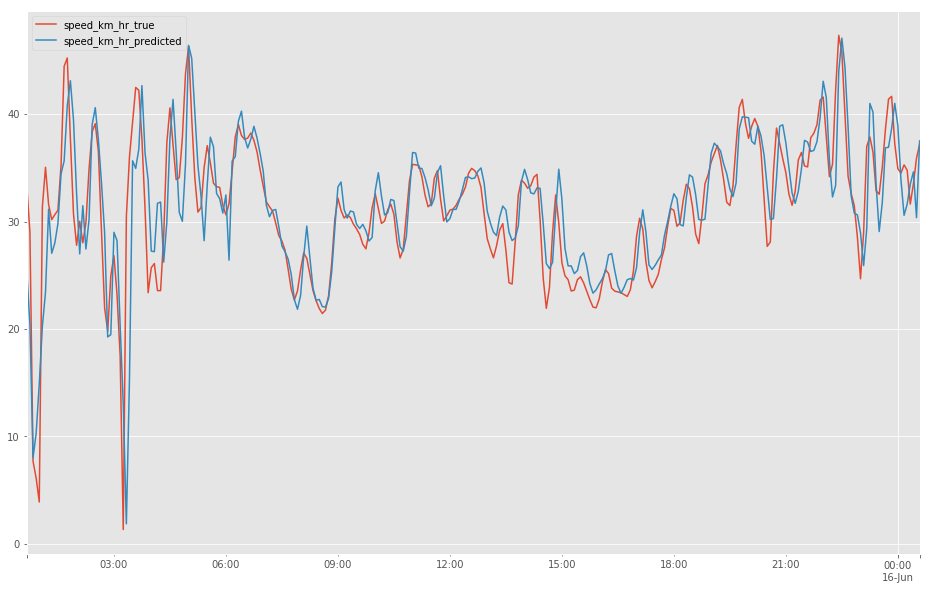

In [131]:
learner.load_best_model_from_disk()
learner.predict()

{'corr': 0.85887030392589636,
 'mae': 1.9790370388139009,
 'mape': inf,
 'mse': 14.369192343355737,
 'msne': inf,
 'r2': 0.72963512579626322,
 'rae': 0.37914546815711342,
 'rmse': 3.7906717535755767,
 'rmsne': inf}

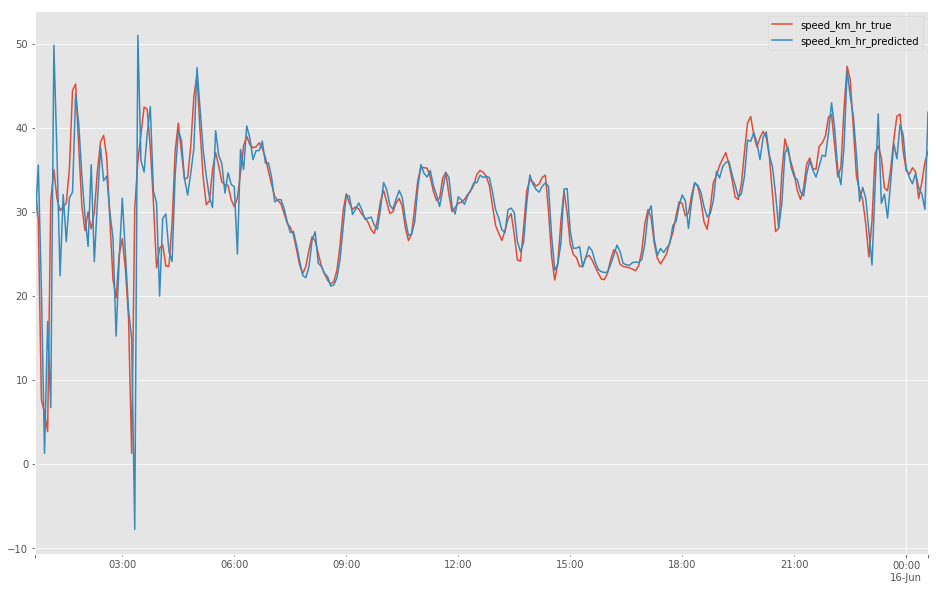

In [128]:
learner.baseline_lr()